In [1]:
# TODO
# Load dataset with conditioning
# Load model
# Generate using the conditioning

In [2]:
import os
import sys
sys.path.append("./")
import yaml

import torch
from torch.utils.data import DataLoader

import numpy as np

from decifer import (
    DeciferConfig,
    Decifer, # TODO make this DeciferModel instead
    DeciferDataset,
    Tokenizer,
    load_model_from_checkpoint,
    extract_prompt
)

In [3]:
# Create dataset
dataset_path = "../data/crystallm/1k/serialized/test.h5"
dataset = DeciferDataset(dataset_path, ["cif_tokenized", "xrd_cont.iq"])

In [18]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = "../cross-contamination/crystal_full_models/boundary_masking/ckpt.pt"
model = load_model_from_checkpoint(ckpt_path, device=device)
model.eval()
# model.train()

number of total parameters: 25.36M


Decifer(
  (transformer): ModuleDict(
    (cond_embedding): None
    (wte): Embedding(372, 512)
    (wpe): Embedding(1024, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=False)
          (c_proj): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=512, out_features=372, bias=False)
)

In [19]:
model.config

DeciferConfig(block_size=1024, vocab_size=372, cond_size=1000, n_layer=8, n_head=8, n_embd=512, dropout=0.1, bias=False, lora_rank=2, use_lora=False, lora_mlp=False, lora_proj=False, condition_with_emb=False, boundary_masking=True)

In [20]:
# Make decoder for tokens->CIFs
decode = Tokenizer().decode

In [21]:
import matplotlib.pyplot as plt

In [30]:
# Sample from dataset
for i, sample in enumerate(iter(dataset)):
    cif_tokens, xrd = sample
    xrd = xrd.to(device=device)
    prompt = extract_prompt(cif_tokens, model.device, add_composition=False, add_spacegroup=False).unsqueeze(0)
    print(decode(cif_tokens.cpu().numpy()), end='\n\n')
    model.generate_and_print(prompt, max_new_tokens=2000, cond_vec=None, start_indices_batch = [[0]], top_k=1)
    
    model.generate_and_print(prompt, max_new_tokens=2000, cond_vec=xrd, start_indices_batch = [[0]], top_k=1)
    break

data_Th2Ni4P4
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type_ionic_radius
Th 1.3000 1.8000 1.0800
Ni 1.9100 1.3500 0.7400
P 2.1900 1.0000 0.5500
_symmetry_space_group_name_H-M P4/nmm
_cell_length_a 4.0833
_cell_length_b 4.0833
_cell_length_c 9.0587
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 129
_chemical_formula_structural Th(NiP)2
_chemical_formula_sum 'Th2 Ni4 P4'
_cell_volume 151.0415
_cell_formula_units_Z 2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1 'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Th Th0 2 0.0000 0.5000 0.7514 1.0000
Ni Ni1 2 0.0000 0.0000 0.0000 1.0000
Ni Ni2 2 0.0000 0.5000 0.3860 1.0000
P P3 2 0.0000 0.0000 0.5000 1.0000
P P4 2 0.0000 0.5000 0.1290 1.0000

data_K4Li4Ca4
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_typ

In [46]:
import pandas as pd
# Open eval data and compare XRD
eval_path = "../cross-contamination/crystal_full_models/boundary_masking_addcomp_5kcrystaltest.eval"
df_eval = pd.read_parquet(eval_path, columns=['descriptors.xrd_gen.iq', 'descriptors.xrd_sample.iq', 'validity.formula', 'validity.bond_length', 'validity.spacegroup', 'validity.site_multiplicity'])
df_eval

,descriptors.xrd_gen.iq,descriptors.xrd_sample.iq,validity.formula,validity.bond_length,validity.spacegroup,validity.site_multiplicity
0,"[1.9235025953579154e-124, 2.2208904531535513e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True
2,"[1.5797148972006304e-167, 3.908407758539395e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True
3,"[2.051494942404434e-198, 8.291455428915949e-19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True
4,"[2.1438523025433757e-111, 1.8930752797417699e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True
...,...,...,...,...,...,...
4995,"[4.239809941028012e-46, 6.892091907247491e-45,...","[0.0, 0.0, 1e-45, 1.4e-44, 2.24e-43, 3.33e-42,...",True,True,True,True
4996,"[2.16786878452678e-179, 6.430218859224642e-177...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True
4997,"[3.2744483921576593e-43, 5.264912197449724e-42...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True
4998,"[4.043715389885166e-105, 3.176418486139862e-10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,True,True,True


In [59]:
from tqdm.auto import tqdm

In [60]:
def rwp(sample, gen):
    return np.sqrt(np.sum(np.square(sample - gen), axis=0) / np.sum(np.square(sample), axis=0))

In [65]:
len(df_eval)

5000

In [94]:
debug_max = None
rwps = []

# Define pbar based on whether debug_max is None or not
if debug_max is not None:
    pbar = tqdm(total=min(debug_max, len(df_eval)))
else:
    pbar = tqdm(total=len(df_eval))

for i, row in df_eval.iterrows():
    if debug_max is not None and i == debug_max:
        break
    gen = row['descriptors.xrd_gen.iq']
    sample = row['descriptors.xrd_sample.iq']
    formula = row['validity.formula']
    bond_length = row['validity.bond_length']
    spacegroup = row['validity.spacegroup']
    site_multiplicity = row['validity.site_multiplicity']
    
    # Check validity conditions
    if np.all([formula, bond_length, spacegroup, site_multiplicity]):
        rwps.append(rwp(sample, gen))

    pbar.update(1)

pbar.close()


  0%|          | 0/5000 [00:00<?, ?it/s]

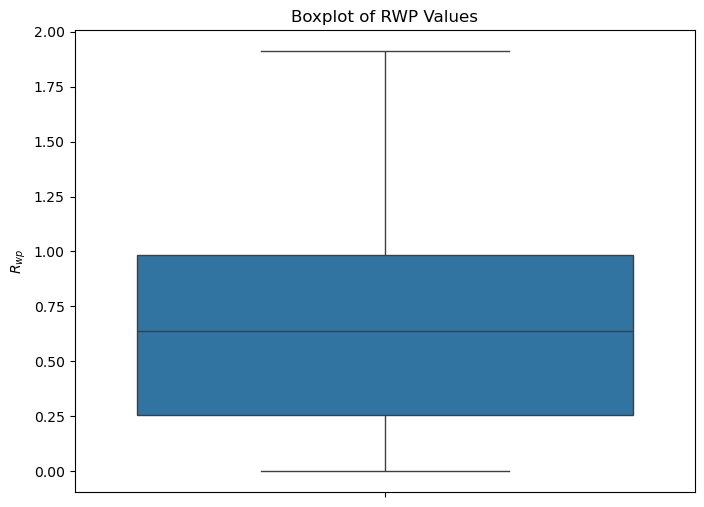

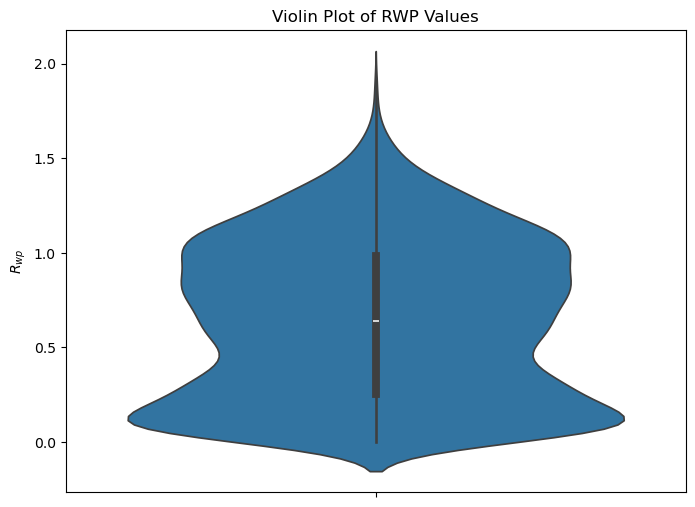

In [101]:
import numpy as np

# Assuming rwps is a list of RWP values

# Convert the list to a numpy array for easier calculations
rwps_array = np.array(rwps)

# Basic statistics
mean_rwp = np.mean(rwps_array)
median_rwp = np.median(rwps_array)
std_rwp = np.std(rwps_array)
min_rwp = np.min(rwps_array)
max_rwp = np.max(rwps_array)

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn boxplot
plt.figure(figsize=(8, 6))  # Set figure size
sns.boxplot(data=rwps_array)

# Add titles and labels
plt.title("Boxplot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

# Assuming rwps is a list of RWP values
rwps_array = np.array(rwps)  # Convert rwps to a numpy array if not already

# Create a seaborn violin plot
plt.figure(figsize=(8, 6))  # Set figure size
sns.violinplot(data=rwps_array)

# Add titles and labels
plt.title("Violin Plot of RWP Values")
plt.ylabel("$R_{wp}$")

# Display the plot
plt.show()

In [105]:
# Generate sample data
np.random.seed(42)  # For reproducibility

stat_dict = {
    'Dataset A': {
        'species': np.random.randint(1, 20, 100),
        'spacegroup': np.random.randint(1, 230, 100),
        'seq_len': np.random.randint(50, 200, 100),
        'cell_params': {
            'a': np.random.uniform(1, 10, 100),
            'b': np.random.uniform(1, 10, 100),
            'c': np.random.uniform(1, 10, 100),
            'alpha': np.random.uniform(60, 120, 100),
            'beta': np.random.uniform(60, 120, 100),
            'gamma': np.random.uniform(60, 120, 100),
            'implied_vol': np.random.uniform(100, 1000, 100),
            'gen_vol': np.random.uniform(100, 1000, 100)
        }
    },
    'Dataset B': {
        'species': np.random.randint(10, 30, 100),
        'spacegroup': np.random.randint(100, 230, 100),
        'seq_len': np.random.randint(150, 300, 100),
        'cell_params': {
            'a': np.random.uniform(5, 15, 100),
            'b': np.random.uniform(5, 15, 100),
            'c': np.random.uniform(5, 15, 100),
            'alpha': np.random.uniform(80, 140, 100),
            'beta': np.random.uniform(80, 140, 100),
            'gamma': np.random.uniform(80, 140, 100),
            'implied_vol': np.random.uniform(500, 1500, 100),
            'gen_vol': np.random.uniform(500, 1500, 100)
        }
    }
}

def plot_histograms(stat_dict, output_dir=None):
    """
    Plot histograms for species, spacegroup, sequence length, and cell parameters.

    Parameters:
        stat_dict (dict): Dictionary containing statistical data.
        output_dir (str, optional): Directory to save output plots. If None, plots will not be saved.
    """
    # Collect all species, spacegroup, seq_len, and cell_params data
    all_species = []
    all_spacegroups = []
    all_seq_len = []
    cell_params = ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'implied_vol', 'gen_vol']
    all_cell_params = {param: [] for param in cell_params}
    dataset_labels_species = []
    dataset_labels_spacegroups = []
    dataset_labels_seq_len = []
    dataset_labels_cell_params = {param: [] for param in cell_params}

    for dataset_name, fields in stat_dict.items():
        all_species.extend(fields['species'])
        all_spacegroups.extend(fields['spacegroup'])
        all_seq_len.extend(fields['seq_len'])
        dataset_labels_species.extend([dataset_name] * len(fields['species']))
        dataset_labels_spacegroups.extend([dataset_name] * len(fields['spacegroup']))
        dataset_labels_seq_len.extend([dataset_name] * len(fields['seq_len']))
        for param in cell_params:
            all_cell_params[param].extend(fields['cell_params'][param])
            dataset_labels_cell_params[param].extend([dataset_name] * len(fields['cell_params'][param]))

    # Define bins
    species_bins = np.linspace(min(all_species), max(all_species), 51)
    spacegroup_bins = np.linspace(min(all_spacegroups), max(all_spacegroups), 51)
    seq_len_bins = np.linspace(min(all_seq_len), max(all_seq_len), 51)
    cell_params_bins = {param: np.linspace(min(all_cell_params[param]), max(all_cell_params[param]), 51) for param in cell_params}

    # Replace inf values with NaN and drop NaNs
    species_data = pd.Series(all_species).replace([np.inf, -np.inf], np.nan).dropna().tolist()
    spacegroup_data = pd.Series(all_spacegroups).replace([np.inf, -np.inf], np.nan).dropna().tolist()
    seq_len_data = pd.Series(all_seq_len).replace([np.inf, -np.inf], np.nan).dropna().tolist()
    for param in cell_params:
        all_cell_params[param] = pd.Series(all_cell_params[param]).replace([np.inf, -np.inf], np.nan).dropna().tolist()

    # Plot histograms
    fig, axes = plt.subplots(4, 3, figsize=(16, 18))  # Increased width to accommodate legend
    axes = axes.ravel()

    # Initialize dictionary to collect handles and labels for the legend
    legend_data = {}

    sns.histplot(
        x=species_data,
        bins=species_bins,
        ax=axes[0],
        hue=dataset_labels_species,
        element='step',
        stat='density',
        common_norm=False
    )
    axes[0].set(title='Species', xlabel='Z')
    # Collect handles and labels from the first plot
    handles, labels = axes[0].get_legend_handles_labels()
    for h, l in zip(handles, labels):
        legend_data[l] = h
        print(h, l)
    # Remove legend from the first axes
    axes[0].get_legend().remove()

    sns.histplot(
        x=spacegroup_data,
        bins=spacegroup_bins,
        ax=axes[1],
        hue=dataset_labels_spacegroups,
        element='step',
        stat='density',
        common_norm=False
    )
    axes[1].set(title='Spacegroup', xlabel='Spg number')
    # Remove legend from this axes
    axes[1].get_legend().remove()

    sns.histplot(
        x=seq_len_data,
        bins=seq_len_bins,
        ax=axes[2],
        hue=dataset_labels_seq_len,
        element='step',
        stat='density',
        common_norm=False
    )
    axes[2].set(title='Sequence Length', xlabel='Seq Len')
    # Remove legend from this axes
    axes[2].get_legend().remove()

    for i, param in enumerate(cell_params):
        try:
            sns.histplot(
                x=all_cell_params[param],
                bins=cell_params_bins[param],
                ax=axes[3+i],
                hue=dataset_labels_cell_params[param],
                element='step',
                stat='density',
                common_norm=False
            )
            axes[3+i].set(title=f'Cell Param: {param}', xlabel=param)
            # Remove legend from this axes
            axes[3+i].get_legend().remove()
        except:
            continue

    for ax in axes.flatten():
        ax.set(ylabel='Density', xlim=(0, None), ylim=(None, None))
        ax.grid(alpha=0.2)

    # Adjust the layout to make room for the legend
    fig.subplots_adjust(right=0.85)

    # Create a unique legend for the entire figure
    print(handles, labels)
    fig.legend(legend_data.values(), legend_data.keys(), loc='center right', bbox_to_anchor=(0.95, 0.5), borderaxespad=0.)

    fig.tight_layout()

    # If output directory is provided, save the plot
    if output_dir:
        save_path = os.path.join(output_dir, 'Histograms.png')
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


[] []


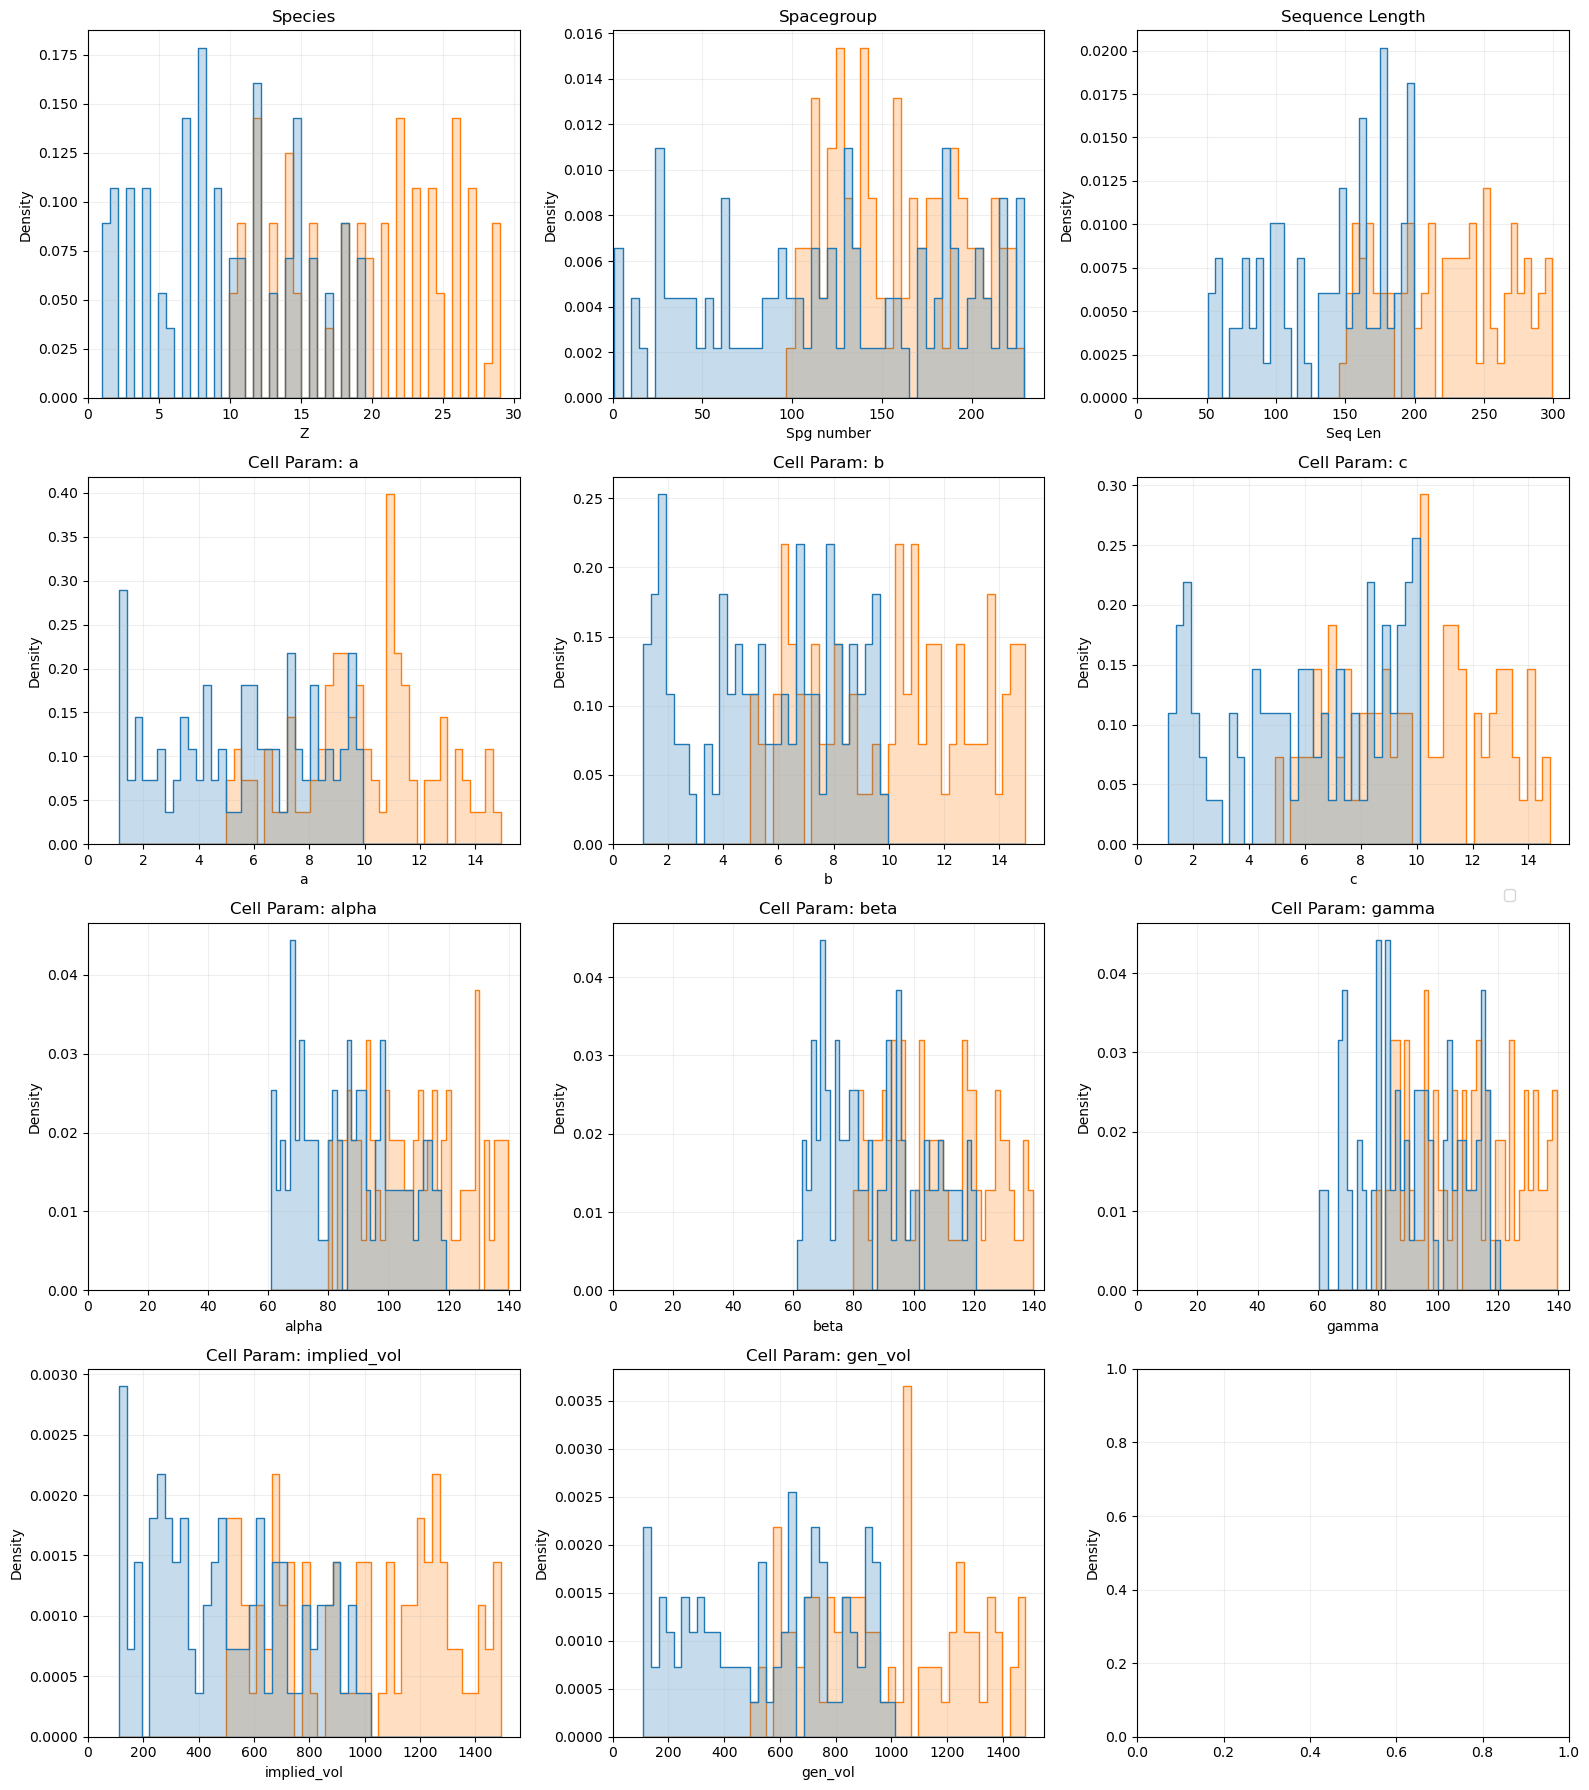

In [106]:
# Generate the plot
plot_histograms(stat_dict)

In [164]:
def plot_histograms(stat_dict, output_dir):
    """
    Plot histograms for species, spacegroup, sequence length, and cell parameters.

    Parameters:
        stat_dict (dict): Dictionary containing statistical data.
        output_dir (str): Directory to save output plots.
    """
    # Collect all species, spacegroup, seq_len, and cell_params data
    all_species = []
    all_spacegroups = []
    all_seq_len = []
    cell_params = ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'implied_vol', 'gen_vol']
    all_cell_params = {param: [] for param in cell_params}
    dataset_labels_species = []
    dataset_labels_spacegroups = []
    dataset_labels_seq_len = []
    dataset_labels_cell_params = {param: [] for param in cell_params}

    for dataset_name, fields in stat_dict.items():
        all_species.extend(fields['species'])
        all_spacegroups.extend(fields['spacegroup'])
        all_seq_len.extend(fields['seq_len'])
        dataset_labels_species.extend([dataset_name] * len(fields['species']))
        dataset_labels_spacegroups.extend([dataset_name] * len(fields['spacegroup']))
        dataset_labels_seq_len.extend([dataset_name] * len(fields['seq_len']))
        for param in cell_params:
            all_cell_params[param].extend(fields['cell_params'][param])
            dataset_labels_cell_params[param].extend([dataset_name] * len(fields['cell_params'][param]))

    # Define bins
    species_bins = np.linspace(min(all_species), max(all_species), 51)
    spacegroup_bins = np.linspace(min(all_spacegroups), max(all_spacegroups), 51)
    seq_len_bins = np.arange(min(all_seq_len), max(all_seq_len) + 1, 51)
    cell_params_bins = {param: np.linspace(min(all_cell_params[param]), max(all_cell_params[param]), 51) for param in cell_params}

    # Replace inf values with NaN and drop NaNs
    species_data = pd.Series(all_species).replace([np.inf, -np.inf], np.nan).dropna().tolist()
    spacegroup_data = pd.Series(all_spacegroups).replace([np.inf, -np.inf], np.nan).dropna().tolist()
    seq_len_data = pd.Series(all_seq_len).replace([np.inf, -np.inf], np.nan).dropna().tolist()
    for param in cell_params:
        all_cell_params[param] = pd.Series(all_cell_params[param]).replace([np.inf, -np.inf], np.nan).dropna().tolist()

    # Plot histograms
    fig, axes = plt.subplots(4, 3, figsize=(14, 18))
    axes = axes.ravel()

    a = sns.histplot(
        x=species_data,
        bins=species_bins,
        ax=axes[0],
        hue=dataset_labels_species,
        element='step',
        stat='density',
        common_norm=False,
        legend=False
    )
    axes[0].set(title='Species', xlabel='Z')

    sns.histplot(
        x=spacegroup_data,
        bins=spacegroup_bins,
        ax=axes[1],
        hue=dataset_labels_spacegroups,
        element='step',
        stat='density',
        common_norm=False,
        legend=False
    )
    axes[1].set(title='Spacegroup', xlabel='Spg number')

    sns.histplot(
        x=seq_len_data,
        bins=seq_len_bins,
        ax=axes[2],
        hue=dataset_labels_seq_len,
        element='step',
        stat='density',
        common_norm=False,
        legend=False
    )
    axes[2].set(title='Sequence Length', xlabel='Seq Len')

    for i, param in enumerate(cell_params):
        try:
            sns.histplot(
                x=all_cell_params[param],
                bins=cell_params_bins[param],
                ax=axes[3+i],
                hue=dataset_labels_cell_params[param],
                element='step',
                stat='density',
                common_norm=False,
                legend=False
            )
            axes[3+i].set(title=f'Cell Param: {param}', xlabel=param)
        except:
            continue
            
    axes[-1].axis('off')
    # Get the position of the axis in figure coordinates
    bbox = axes[-1].get_position()

    # Extract the upper left corner of the bounding box
    upper_left = (bbox.x0+0.025, bbox.y1-0.05)  # (x0, y1) corresponds to the upper left

    for ax in axes.flatten():
        ax.set(ylabel='Density', xlim=(0, None), ylim=(None, None))
        ax.grid(alpha=0.2)
        
    fig.legend(labels=stat_dict.keys(), loc='upper left', bbox_to_anchor=upper_left)

    fig.tight_layout()
    plt.show()

([], [])


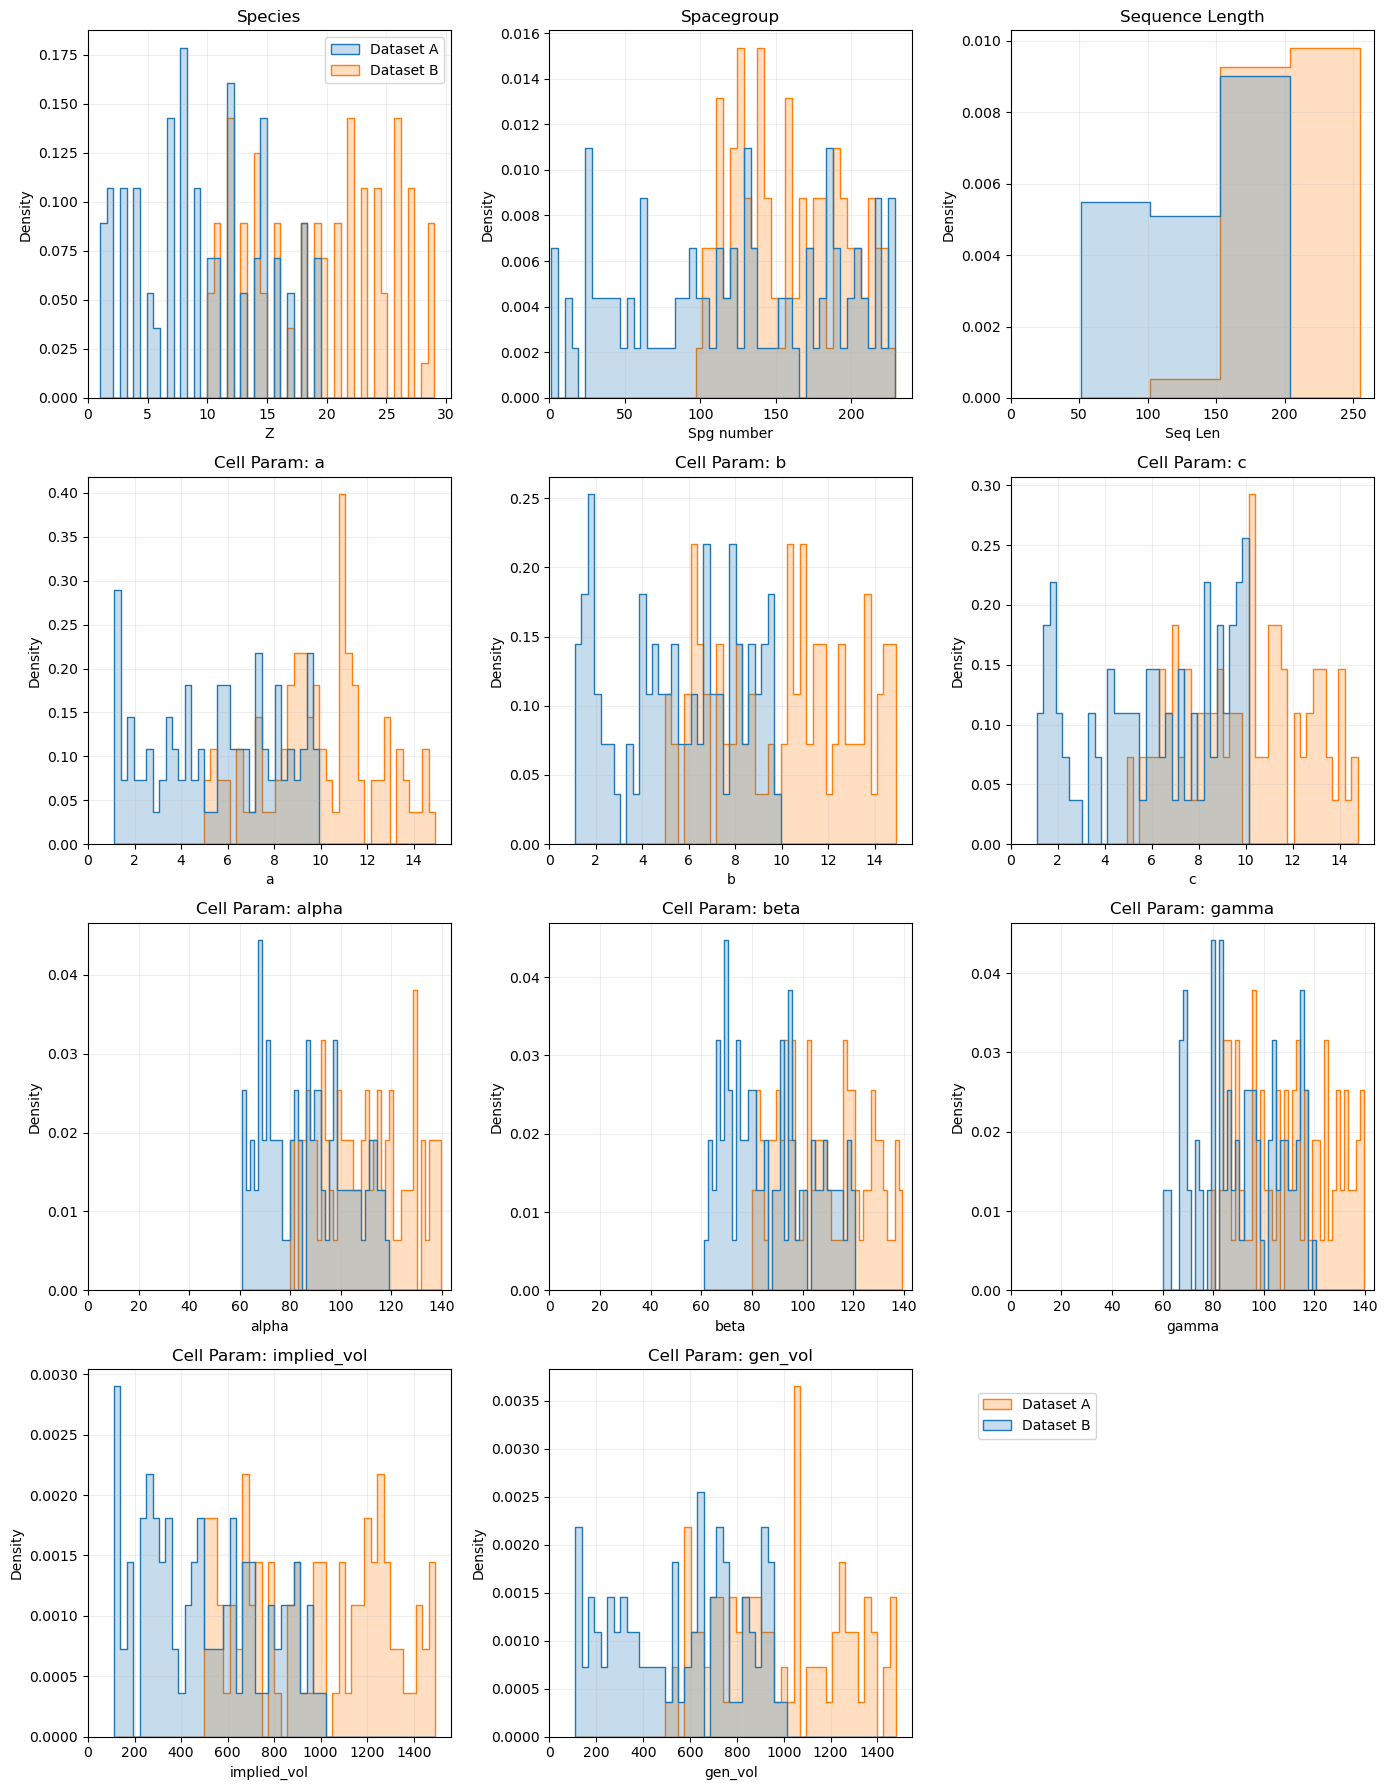

In [165]:
# Generate the plot
plot_histograms(stat_dict)